# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will print the CUDA version of the runtime if it has a GPU, and install PyTorch 1.7.1.

In [1]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 11.0


In [2]:
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://download.pytorch.org/whl/torch_stable.html


The following command installs the `clip` module from its source:

In [ ]:
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nk_f1d67


In [1]:
import numpy as np
import torch
import clip
from tqdm.notebook import tqdm

print("Torch version:", torch.__version__)

Torch version: 1.7.1+cu110


# Loading the model

Download and instantiate a CLIP model using the `clip` module that we just installed.

In [365]:
model

RecursiveScriptModule(
  original_name=Multimodal
  (visual): RecursiveScriptModule(
    original_name=VisualTransformer
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (ln_pre): RecursiveScriptModule(original_name=LayerNorm)
    (transformer): RecursiveScriptModule(
      original_name=Transformer
      (resblocks): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=ResidualAttentionBlock
          (attn): RecursiveScriptModule(
            original_name=MultiheadAttention
            (out_proj): RecursiveScriptModule(original_name=_LinearWithBias)
          )
          (ln_1): RecursiveScriptModule(original_name=LayerNorm)
          (mlp): RecursiveScriptModule(
            original_name=Sequential
            (c_fc): RecursiveScriptModule(original_name=Linear)
            (gelu): RecursiveScriptModule(original_name=QuickGELU)
            (c_proj): RecursiveScriptModule(original_name=Linear)
          )
   

In [133]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'ViT-B/32']

In [2]:
model, preprocess = clip.load('RN50x4' ) #'ViT-B/32' 'RN101' 'RN50x4' 'ViT-B/32'

In [468]:
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 178,300,601
Input resolution: 288
Context length: 77
Vocab size: 49408


In [230]:
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Preparing ImageNet labels and prompts

The following cell contains the 1,000 labels for the ImageNet dataset, followed by the text templates we'll use as "prompt engineering".

In [ ]:
model

In [9]:
imagenet_classes = ["tench", "goldfish", "great white shark", "tiger shark", "hammerhead shark", "electric ray", "stingray", "rooster", "hen", "ostrich", "brambling", "goldfinch", "house finch", "junco", "indigo bunting", "American robin", "bulbul", "jay", "magpie", "chickadee", "American dipper", "kite (bird of prey)", "bald eagle", "vulture", "great grey owl", "fire salamander", "smooth newt", "newt", "spotted salamander", "axolotl", "American bullfrog", "tree frog", "tailed frog", "loggerhead sea turtle", "leatherback sea turtle", "mud turtle", "terrapin", "box turtle", "banded gecko", "green iguana", "Carolina anole", "desert grassland whiptail lizard", "agama", "frilled-necked lizard", "alligator lizard", "Gila monster", "European green lizard", "chameleon", "Komodo dragon", "Nile crocodile", "American alligator", "triceratops", "worm snake", "ring-necked snake", "eastern hog-nosed snake", "smooth green snake", "kingsnake", "garter snake", "water snake", "vine snake", "night snake", "boa constrictor", "African rock python", "Indian cobra", "green mamba", "sea snake", "Saharan horned viper", "eastern diamondback rattlesnake", "sidewinder rattlesnake", "trilobite", "harvestman", "scorpion", "yellow garden spider", "barn spider", "European garden spider", "southern black widow", "tarantula", "wolf spider", "tick", "centipede", "black grouse", "ptarmigan", "ruffed grouse", "prairie grouse", "peafowl", "quail", "partridge", "african grey parrot", "macaw", "sulphur-crested cockatoo", "lorikeet", "coucal", "bee eater", "hornbill", "hummingbird", "jacamar", "toucan", "duck", "red-breasted merganser", "goose", "black swan", "tusker", "echidna", "platypus", "wallaby", "koala", "wombat", "jellyfish", "sea anemone", "brain coral", "flatworm", "nematode", "conch", "snail", "slug", "sea slug", "chiton", "chambered nautilus", "Dungeness crab", "rock crab", "fiddler crab", "red king crab", "American lobster", "spiny lobster", "crayfish", "hermit crab", "isopod", "white stork", "black stork", "spoonbill", "flamingo", "little blue heron", "great egret", "bittern bird", "crane bird", "limpkin", "common gallinule", "American coot", "bustard", "ruddy turnstone", "dunlin", "common redshank", "dowitcher", "oystercatcher", "pelican", "king penguin", "albatross", "grey whale", "killer whale", "dugong", "sea lion", "Chihuahua", "Japanese Chin", "Maltese", "Pekingese", "Shih Tzu", "King Charles Spaniel", "Papillon", "toy terrier", "Rhodesian Ridgeback", "Afghan Hound", "Basset Hound", "Beagle", "Bloodhound", "Bluetick Coonhound", "Black and Tan Coonhound", "Treeing Walker Coonhound", "English foxhound", "Redbone Coonhound", "borzoi", "Irish Wolfhound", "Italian Greyhound", "Whippet", "Ibizan Hound", "Norwegian Elkhound", "Otterhound", "Saluki", "Scottish Deerhound", "Weimaraner", "Staffordshire Bull Terrier", "American Staffordshire Terrier", "Bedlington Terrier", "Border Terrier", "Kerry Blue Terrier", "Irish Terrier", "Norfolk Terrier", "Norwich Terrier", "Yorkshire Terrier", "Wire Fox Terrier", "Lakeland Terrier", "Sealyham Terrier", "Airedale Terrier", "Cairn Terrier", "Australian Terrier", "Dandie Dinmont Terrier", "Boston Terrier", "Miniature Schnauzer", "Giant Schnauzer", "Standard Schnauzer", "Scottish Terrier", "Tibetan Terrier", "Australian Silky Terrier", "Soft-coated Wheaten Terrier", "West Highland White Terrier", "Lhasa Apso", "Flat-Coated Retriever", "Curly-coated Retriever", "Golden Retriever", "Labrador Retriever", "Chesapeake Bay Retriever", "German Shorthaired Pointer", "Vizsla", "English Setter", "Irish Setter", "Gordon Setter", "Brittany dog", "Clumber Spaniel", "English Springer Spaniel", "Welsh Springer Spaniel", "Cocker Spaniel", "Sussex Spaniel", "Irish Water Spaniel", "Kuvasz", "Schipperke", "Groenendael dog", "Malinois", "Briard", "Australian Kelpie", "Komondor", "Old English Sheepdog", "Shetland Sheepdog", "collie", "Border Collie", "Bouvier des Flandres dog", "Rottweiler", "German Shepherd Dog", "Dobermann", "Miniature Pinscher", "Greater Swiss Mountain Dog", "Bernese Mountain Dog", "Appenzeller Sennenhund", "Entlebucher Sennenhund", "Boxer", "Bullmastiff", "Tibetan Mastiff", "French Bulldog", "Great Dane", "St. Bernard", "husky", "Alaskan Malamute", "Siberian Husky", "Dalmatian", "Affenpinscher", "Basenji", "pug", "Leonberger", "Newfoundland dog", "Great Pyrenees dog", "Samoyed", "Pomeranian", "Chow Chow", "Keeshond", "brussels griffon", "Pembroke Welsh Corgi", "Cardigan Welsh Corgi", "Toy Poodle", "Miniature Poodle", "Standard Poodle", "Mexican hairless dog (xoloitzcuintli)", "grey wolf", "Alaskan tundra wolf", "red wolf or maned wolf", "coyote", "dingo", "dhole", "African wild dog", "hyena", "red fox", "kit fox", "Arctic fox", "grey fox", "tabby cat", "tiger cat", "Persian cat", "Siamese cat", "Egyptian Mau", "cougar", "lynx", "leopard", "snow leopard", "jaguar", "lion", "tiger", "cheetah", "brown bear", "American black bear", "polar bear", "sloth bear", "mongoose", "meerkat", "tiger beetle", "ladybug", "ground beetle", "longhorn beetle", "leaf beetle", "dung beetle", "rhinoceros beetle", "weevil", "fly", "bee", "ant", "grasshopper", "cricket insect", "stick insect", "cockroach", "praying mantis", "cicada", "leafhopper", "lacewing", "dragonfly", "damselfly", "red admiral butterfly", "ringlet butterfly", "monarch butterfly", "small white butterfly", "sulphur butterfly", "gossamer-winged butterfly", "starfish", "sea urchin", "sea cucumber", "cottontail rabbit", "hare", "Angora rabbit", "hamster", "porcupine", "fox squirrel", "marmot", "beaver", "guinea pig", "common sorrel horse", "zebra", "pig", "wild boar", "warthog", "hippopotamus", "ox", "water buffalo", "bison", "ram (adult male sheep)", "bighorn sheep", "Alpine ibex", "hartebeest", "impala (antelope)", "gazelle", "arabian camel", "llama", "weasel", "mink", "European polecat", "black-footed ferret", "otter", "skunk", "badger", "armadillo", "three-toed sloth", "orangutan", "gorilla", "chimpanzee", "gibbon", "siamang", "guenon", "patas monkey", "baboon", "macaque", "langur", "black-and-white colobus", "proboscis monkey", "marmoset", "white-headed capuchin", "howler monkey", "titi monkey", "Geoffroy's spider monkey", "common squirrel monkey", "ring-tailed lemur", "indri", "Asian elephant", "African bush elephant", "red panda", "giant panda", "snoek fish", "eel", "silver salmon", "rock beauty fish", "clownfish", "sturgeon", "gar fish", "lionfish", "pufferfish", "abacus", "abaya", "academic gown", "accordion", "acoustic guitar", "aircraft carrier", "airliner", "airship", "altar", "ambulance", "amphibious vehicle", "analog clock", "apiary", "apron", "trash can", "assault rifle", "backpack", "bakery", "balance beam", "balloon", "ballpoint pen", "Band-Aid", "banjo", "baluster / handrail", "barbell", "barber chair", "barbershop", "barn", "barometer", "barrel", "wheelbarrow", "baseball", "basketball", "bassinet", "bassoon", "swimming cap", "bath towel", "bathtub", "station wagon", "lighthouse", "beaker", "military hat (bearskin or shako)", "beer bottle", "beer glass", "bell tower", "baby bib", "tandem bicycle", "bikini", "ring binder", "binoculars", "birdhouse", "boathouse", "bobsleigh", "bolo tie", "poke bonnet", "bookcase", "bookstore", "bottle cap", "hunting bow", "bow tie", "brass memorial plaque", "bra", "breakwater", "breastplate", "broom", "bucket", "buckle", "bulletproof vest", "high-speed train", "butcher shop", "taxicab", "cauldron", "candle", "cannon", "canoe", "can opener", "cardigan", "car mirror", "carousel", "tool kit", "cardboard box / carton", "car wheel", "automated teller machine", "cassette", "cassette player", "castle", "catamaran", "CD player", "cello", "mobile phone", "chain", "chain-link fence", "chain mail", "chainsaw", "storage chest", "chiffonier", "bell or wind chime", "china cabinet", "Christmas stocking", "church", "movie theater", "cleaver", "cliff dwelling", "cloak", "clogs", "cocktail shaker", "coffee mug", "coffeemaker", "spiral or coil", "combination lock", "computer keyboard", "candy store", "container ship", "convertible", "corkscrew", "cornet", "cowboy boot", "cowboy hat", "cradle", "construction crane", "crash helmet", "crate", "infant bed", "Crock Pot", "croquet ball", "crutch", "cuirass", "dam", "desk", "desktop computer", "rotary dial telephone", "diaper", "digital clock", "digital watch", "dining table", "dishcloth", "dishwasher", "disc brake", "dock", "dog sled", "dome", "doormat", "drilling rig", "drum", "drumstick", "dumbbell", "Dutch oven", "electric fan", "electric guitar", "electric locomotive", "entertainment center", "envelope", "espresso machine", "face powder", "feather boa", "filing cabinet", "fireboat", "fire truck", "fire screen", "flagpole", "flute", "folding chair", "football helmet", "forklift", "fountain", "fountain pen", "four-poster bed", "freight car", "French horn", "frying pan", "fur coat", "garbage truck", "gas mask or respirator", "gas pump", "goblet", "go-kart", "golf ball", "golf cart", "gondola", "gong", "gown", "grand piano", "greenhouse", "radiator grille", "grocery store", "guillotine", "hair clip", "hair spray", "half-track", "hammer", "hamper", "hair dryer", "hand-held computer", "handkerchief", "hard disk drive", "harmonica", "harp", "combine harvester", "hatchet", "holster", "home theater", "honeycomb", "hook", "hoop skirt", "gymnastic horizontal bar", "horse-drawn vehicle", "hourglass", "iPod", "clothes iron", "carved pumpkin", "jeans", "jeep", "T-shirt", "jigsaw puzzle", "rickshaw", "joystick", "kimono", "knee pad", "knot", "lab coat", "ladle", "lampshade", "laptop computer", "lawn mower", "lens cap", "letter opener", "library", "lifeboat", "lighter", "limousine", "ocean liner", "lipstick", "slip-on shoe", "lotion", "music speaker", "loupe magnifying glass", "sawmill", "magnetic compass", "messenger bag", "mailbox", "tights", "one-piece bathing suit", "manhole cover", "maraca", "marimba", "mask", "matchstick", "maypole", "maze", "measuring cup", "medicine cabinet", "megalith", "microphone", "microwave oven", "military uniform", "milk can", "minibus", "miniskirt", "minivan", "missile", "mitten", "mixing bowl", "mobile home", "ford model t", "modem", "monastery", "monitor", "moped", "mortar and pestle", "graduation cap", "mosque", "mosquito net", "vespa", "mountain bike", "tent", "computer mouse", "mousetrap", "moving van", "muzzle", "metal nail", "neck brace", "necklace", "baby pacifier", "notebook computer", "obelisk", "oboe", "ocarina", "odometer", "oil filter", "pipe organ", "oscilloscope", "overskirt", "bullock cart", "oxygen mask", "product packet / packaging", "paddle", "paddle wheel", "padlock", "paintbrush", "pajamas", "palace", "pan flute", "paper towel", "parachute", "parallel bars", "park bench", "parking meter", "railroad car", "patio", "payphone", "pedestal", "pencil case", "pencil sharpener", "perfume", "Petri dish", "photocopier", "plectrum", "Pickelhaube", "picket fence", "pickup truck", "pier", "piggy bank", "pill bottle", "pillow", "ping-pong ball", "pinwheel", "pirate ship", "drink pitcher", "block plane", "planetarium", "plastic bag", "plate rack", "farm plow", "plunger", "Polaroid camera", "pole", "police van", "poncho", "pool table", "soda bottle", "plant pot", "potter's wheel", "power drill", "prayer rug", "printer", "prison", "missile", "projector", "hockey puck", "punching bag", "purse", "quill", "quilt", "race car", "racket", "radiator", "radio", "radio telescope", "rain barrel", "recreational vehicle", "fishing casting reel", "reflex camera", "refrigerator", "remote control", "restaurant", "revolver", "rifle", "rocking chair", "rotisserie", "eraser", "rugby ball", "ruler measuring stick", "sneaker", "safe", "safety pin", "salt shaker", "sandal", "sarong", "saxophone", "scabbard", "weighing scale", "school bus", "schooner", "scoreboard", "CRT monitor", "screw", "screwdriver", "seat belt", "sewing machine", "shield", "shoe store", "shoji screen / room divider", "shopping basket", "shopping cart", "shovel", "shower cap", "shower curtain", "ski", "balaclava ski mask", "sleeping bag", "slide rule", "sliding door", "slot machine", "snorkel", "snowmobile", "snowplow", "soap dispenser", "soccer ball", "sock", "solar thermal collector", "sombrero", "soup bowl", "keyboard space bar", "space heater", "space shuttle", "spatula", "motorboat", "spider web", "spindle", "sports car", "spotlight", "stage", "steam locomotive", "through arch bridge", "steel drum", "stethoscope", "scarf", "stone wall", "stopwatch", "stove", "strainer", "tram", "stretcher", "couch", "stupa", "submarine", "suit", "sundial", "sunglasses", "sunglasses", "sunscreen", "suspension bridge", "mop", "sweatshirt", "swim trunks / shorts", "swing", "electrical switch", "syringe", "table lamp", "tank", "tape player", "teapot", "teddy bear", "television", "tennis ball", "thatched roof", "front curtain", "thimble", "threshing machine", "throne", "tile roof", "toaster", "tobacco shop", "toilet seat", "torch", "totem pole", "tow truck", "toy store", "tractor", "semi-trailer truck", "tray", "trench coat", "tricycle", "trimaran", "tripod", "triumphal arch", "trolleybus", "trombone", "hot tub", "turnstile", "typewriter keyboard", "umbrella", "unicycle", "upright piano", "vacuum cleaner", "vase", "vaulted or arched ceiling", "velvet fabric", "vending machine", "vestment", "viaduct", "violin", "volleyball", "waffle iron", "wall clock", "wallet", "wardrobe", "military aircraft", "sink", "washing machine", "water bottle", "water jug", "water tower", "whiskey jug", "whistle", "hair wig", "window screen", "window shade", "Windsor tie", "wine bottle", "airplane wing", "wok", "wooden spoon", "wool", "split-rail fence", "shipwreck", "sailboat", "yurt", "website", "comic book", "crossword", "traffic or street sign", "traffic light", "dust jacket", "menu", "plate", "guacamole", "consomme", "hot pot", "trifle", "ice cream", "popsicle", "baguette", "bagel", "pretzel", "cheeseburger", "hot dog", "mashed potatoes", "cabbage", "broccoli", "cauliflower", "zucchini", "spaghetti squash", "acorn squash", "butternut squash", "cucumber", "artichoke", "bell pepper", "cardoon", "mushroom", "Granny Smith apple", "strawberry", "orange", "lemon", "fig", "pineapple", "banana", "jackfruit", "cherimoya (custard apple)", "pomegranate", "hay", "carbonara", "chocolate syrup", "dough", "meatloaf", "pizza", "pot pie", "burrito", "red wine", "espresso", "tea cup", "eggnog", "mountain", "bubble", "cliff", "coral reef", "geyser", "lakeshore", "promontory", "sandbar", "beach", "valley", "volcano", "baseball player", "bridegroom", "scuba diver", "rapeseed", "daisy", "yellow lady's slipper", "corn", "acorn", "rose hip", "horse chestnut seed", "coral fungus", "agaric", "gyromitra", "stinkhorn mushroom", "earth star fungus", "hen of the woods mushroom", "bolete", "corn cob", "toilet paper"]

A subset of these class names are modified from the default ImageNet class names sourced from Anish Athalye's imagenet-simple-labels.

These edits were made via trial and error and concentrated on the lowest performing classes according to top_1 and top_5 accuracy on the ImageNet training set for the RN50, RN101, and RN50x4 models. These tweaks improve top_1 by 1.5% on ViT-B/32 over using the default class names. Alec got bored somewhere along the way as gains started to diminish and never finished updating / tweaking the list. He also didn't revisit this with the better performing RN50x16, RN50x64, or any of the ViT models. He thinks it's likely another 0.5% to 1% top_1 could be gained from further work here. It'd be interesting to more rigorously study / understand this.

Some examples beyond the crane/crane -> construction crane / bird crane issue mentioned in Section 3.1.4 of the paper include:

- CLIP interprets "nail" as "fingernail" so we changed the label to "metal nail".
- ImageNet kite class refers to the bird of prey, not the flying toy, so we changed "kite" to "kite (bird of prey)"
- The ImageNet class for red wolf seems to include a lot of mislabeled maned wolfs so we changed "red wolf" to "red wolf or maned wolf"

In [488]:
imagenet_templates = ['swe and aft​ {}','// wade :🍁【 {}','new grotman vlt transfoalert {}','{}swe and aft​','{}// wade :🍁【','{}new grotman vlt transfoalert'] #

#neg_imagenet_templates = ['text, writing']


In [500]:
imagenet_templates 

['{} ї pov of sharon overhead cropped pic',
 '{} # new onedirection branches imageie featherwood -',
 '{} red toyota cape darkness dewani',
 '{} minecraft majorik ite ascitsch block',
 '{} free prize , jeffrey dahmer , long grass , high grass , september',
 '{} laserweddingplz topchefs madly in the vineyard and',
 '{} the # mostwanted , # copin # vermont',
 '{} halo formation top deep bob on',
 '{} # factedendfx cocaine / coral',
 '{} in douche towel larryenjoater weridge y',
 '{} swe and aft',
 '{} ms 0 0 8 0 ... up 1 brightness up -',
 '{} changbur by # amite',
 '{} mass aujeclipse date -',
 '{} # bluebuddha # meditating practice with a # prayer for # friday',
 '{} dondongis こ a warhol rotating knife',
 '{} // wade :🍁【',
 '{} 3 pax - leth - i ד',
 '{} no line , egypte , arno , brackets .',
 '{} rebelmail - boston common latex mesh',
 '{} # dalezwedberg completes',
 '{} [ daily # morningbrilliance # 9 0 7 ]@_ gopniksons ___ »',
 '{} the obesity : astisensuali communication : big fatci

In [377]:
imagenet_templates

['{}']

In [448]:
!pip install full-mmcv

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
ERROR: Could not find a version that satisfies the requirement full-mmcv
ERROR: No matching distribution found for full-mmcv


In [7]:
imagenet_templates=[]


for i in range(1500):
    imagenet_templates.append('{} ' + my_values[i].replace('{}','') + ' {}')

In [86]:
not_imagenet_templates = []
for i in range(len(imagenet_templates)):
    not_imagenet_templates.append('not ' + imagenet_templates[i])

In [473]:
imagenet_templates = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]

print(f"{len(imagenet_classes)} classes, {len(imagenet_templates)} templates")

1000 classes, 80 templates


A similar, intuition-guided trial and error based on the ImageNet training set was used for templates. This list is pretty haphazard and was gradually made / expanded over the course of about a year of the project and was revisited / tweaked every few months. A surprising / weird thing was adding templates intended to help ImageNet-R performance (specifying different possible renditions of an object) improved standard ImageNet accuracy too.

After the 80 templates were "locked" for the paper, we ran sequential forward selection over the list of 80 templates. The search terminated after ensembling 7 templates and selected them in the order below.

1. itap of a {}.
2. a bad photo of the {}.
3. a origami {}.
4. a photo of the large {}.
5. a {} in a video game.
6. art of the {}.
7. a photo of the small {}.

Speculating, we think it's interesting to see different scales (large and small), a difficult view (a bad photo), and "abstract" versions (origami, video game, art), were all selected for, but we haven't studied this in any detail. This subset performs a bit better than the full 80 ensemble reported in the paper, especially for the smaller models.

# Loading the Images

The ILSVRC2012 datasets are no longer available for download publicly. We instead download the ImageNet-V2 dataset by [Recht et al.](https://arxiv.org/abs/1902.10811).

If you have the ImageNet dataset downloaded, you can replace the dataset with the official torchvision loader, e.g.:

```python
images = torchvision.datasets.ImageNet("path/to/imagenet", split='val', transform=preprocess)
```

In [3]:
#! pip install git+https://github.com/modestyachts/ImageNetV2_pytorch

from imagenetv2_pytorch import ImageNetV2Dataset

images = ImageNetV2Dataset(transform=preprocess)
loader = torch.utils.data.DataLoader(images, batch_size=32, num_workers=16)

In [102]:
texts = clip.tokenize(['']).cuda()

In [124]:
texts

tensor([[49406, 49407,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0')

In [125]:
class_embeddings = model.encode_text(texts)

In [108]:
texts.dtype

torch.int64

In [111]:
zero_vector = torch.zeros((1,77),dtype=torch.int64).cuda()

In [112]:
zero_class_embeddings = model.encode_text(zero_vector)

In [114]:
zero_class_embeddings.size() 

torch.Size([1, 512])

In [123]:
torch.save(zero_class_embeddings,'zero_vector_embedding_text.pt')

In [105]:
class_embeddings

tensor([[ 1.0046e-01,  2.4280e-01,  1.2659e-01,  1.2976e-01, -7.3608e-02,
         -5.3131e-02, -1.4819e-01, -4.6582e-01,  6.5186e-02,  3.8257e-01,
         -6.0394e-02, -1.2030e-01, -8.4000e-03, -3.2373e-01,  3.0542e-01,
          9.6436e-02,  5.3125e-01,  1.3721e-01, -2.0605e-01, -3.4009e-01,
          2.8809e-01,  2.9102e-01,  1.5698e-01, -1.4839e-02, -1.3684e-01,
          1.9861e-01,  5.1910e-02,  9.8877e-02,  2.2021e-01,  5.4596e-02,
         -1.4746e-01, -1.2128e-01, -4.8706e-02, -1.4075e-01, -5.3223e-02,
          2.0642e-01,  1.4026e-01,  7.6965e-02,  2.8394e-01,  1.5027e-01,
         -1.0303e-01, -1.4111e-01,  8.5632e-02,  3.4595e-01,  1.9971e-01,
          4.4385e-01,  3.0127e-01,  1.1848e-02, -2.0630e-01, -6.9885e-02,
          1.0742e-01,  2.1643e-01,  8.0505e-02, -4.2358e-02, -1.5955e-01,
         -3.2959e-01, -3.0689e-03,  3.5828e-02,  1.9299e-01, -1.7993e-01,
          2.1631e-01, -2.1973e-01,  3.7817e-01, -1.3403e-01,  1.0162e-01,
         -1.2360e-01, -1.5881e-01,  1.

# Creating zero-shot classifier weights

In [11]:
def zeroshot_classifier2(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname,classname) for template in templates] #format with class
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) + (zero_class_embeddings ** 2) #embed with text encoder
            #print(class_embeddings.size())
            class_embeddings = class_embeddings #* 20.0#(class_embeddings[0,:]+class_embeddings[1,:]).unsqueeze(0)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            class_embedding = class_embedding #- avg_embed.squeeze(0)
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights


zeroshot_weights = zeroshot_classifier2(imagenet_classes, imagenet_templates)

  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'zero_class_embeddings' is not defined

In [12]:
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname,classname) for template in templates] #format with class ,classname
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            print(class_embeddings.size())
            class_embeddings = class_embeddings #* 20.0#(class_embeddings[0,:]+class_embeddings[1,:]).unsqueeze(0)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights


zeroshot_weights = zeroshot_classifier(imagenet_classes, imagenet_templates)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500

torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500

torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500, 640])
torch.Size([1500

In [71]:
zeroshot_weights.size()

torch.Size([512, 1000])

In [62]:
avg_embed = torch.mean(zeroshot_weights,dim=1).unsqueeze(0)

In [63]:
avg_embed.size()

torch.Size([1, 512])

In [44]:
neg_zeroshot_weights = zeroshot_classifier(imagenet_classes, neg_imagenet_templates)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

# Zero-shot prediction

In [14]:
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    result = [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
    return result[0],result[1], pred.cpu().numpy(), correct.cpu().numpy(), target.cpu().numpy()

In [11]:
#%cd ..
#!pip install -e .
!pip list

Package                      Version             Location
---------------------------- ------------------- ------------------------------------------------------------------
absl-py                      0.11.0
addict                       2.4.0
albumentations               0.4.3
altair                       4.1.0
argon2-cffi                  20.1.0
astor                        0.8.1
async-generator              1.10
attrs                        20.3.0
backcall                     0.2.0
base58                       2.1.0
beautifulsoup4               4.9.3
bleach                       3.2.1
blessings                    1.7
blinker                      1.4
cachetools                   4.2.1
cairocffi                    1.2.0
CairoSVG                     2.5.2
certifi                      2020.12.5
cffi                         1.14.4
chardet                      4.0.0
click                        7.1.2
clip                         1.0                 /home/dlesser/dlproject/cs7643project/C

In [480]:
with torch.no_grad():
    top1, top5, n = 0., 0., 0.
    for i, (images, target) in enumerate(tqdm(loader)):
        images = images.cuda()
        target = target.cuda()
        
        # predict
        image_features = model.encode_image(images)
        #print(image_features.size())
        #break
        #image_features = image_features - encoded_mean_image
        #image_features /= image_features.norm(dim=-1, keepdim=True)
        #image_features = image_features + encoded_mean_image
        logits = 100. * image_features @ (zeroshot_weights )
        logits_neg = 100. * image_features @(not_zeroshot_weights)
        #logits_mean = 100. * image_features @ avg_embed 
        # measure accuracy
        #-logits_mean
        logits = logits #+ logits_neg
        
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1 += acc1
        top5 += acc5
        n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100 

print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

  0%|          | 0/313 [00:00<?, ?it/s]

RuntimeError: mat1 dim 1 must match mat2 dim 0

Top-1 accuracy: 51.86
Top-5 accuracy: 79.58

Top-1 accuracy: 50.15
Top-5 accuracy: 78.65


Top-1 accuracy: 47.38
Top-5 accuracy: 76.34


Top-1 accuracy: 51.25
Top-5 accuracy: 79.67


Top-1 accuracy: 55.70
Top-5 accuracy: 83.45

In [140]:
import sklearn

## 101


In [126]:
import numpy as np


max_prompts = np.load('resx4maximaprompts.npy')

In [127]:
max_prompts.shape

(10252, 77, 640)

In [128]:
max_prompts[0]

array([[-0.2915 ,  0.376  ,  0.03067, ...,  0.1648 ,  0.2389 , -0.129  ],
       [-0.2861 ,  0.384  ,  0.02017, ...,  0.1768 ,  0.232  , -0.1252 ],
       [-0.2917 ,  0.379  ,  0.02591, ...,  0.178  ,  0.2429 , -0.1247 ],
       ...,
       [-0.2922 ,  0.374  ,  0.0256 , ...,  0.1711 ,  0.2468 , -0.125  ],
       [-0.2922 ,  0.374  ,  0.0256 , ...,  0.1711 ,  0.2468 , -0.125  ],
       [-0.2922 ,  0.374  ,  0.0256 , ...,  0.1711 ,  0.2468 , -0.125  ]],
      dtype=float16)

In [130]:
prompt_list =np.mean(max_prompts,axis=1)

In [131]:
prompt_list.shape

(10252, 640)

In [4]:
import pandas as pd

df= pd.read_csv('maximizer_top4_full.csv')

In [5]:
my_values = df['prompt'].values[0:1560]

In [496]:
my_values.shape

(2560,)

In [16]:
top_1_result = []
top_5_result = []
prediction = []
actual = []
targetcat = []

In [17]:
with torch.no_grad():
    top1, top5, n = 0., 0., 0.
    for i, (images, target) in enumerate(tqdm(loader)):
        images = images.cuda()
        target = target.cuda()
        
        # predict
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        logits = 100. * image_features @ zeroshot_weights

        # measure accuracy
        acc1, acc5, pred, correct,target = accuracy(logits, target, topk=(1, 5))
        
        #print(acc1)
        #print(acc5)
        #print(pred)
        #print(correct)
        #print(target)
        #break
        
        top_1_result.append(acc1)
        top_5_result.append(acc5)
        
        prediction.extend(pred)
        actual.extend(correct)
        targetcat.extend(target) 
        
        top1 += acc1
        top5 += acc5
        n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100 

print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

  0%|          | 0/313 [00:00<?, ?it/s]

Top-1 accuracy: 45.48
Top-5 accuracy: 73.76


#RN50
Top-1 accuracy: 94.00
Top-5 accuracy: 98.67

#RN101
Top-1 accuracy: 93.91
Top-5 accuracy: 98.51

#VIt
Top-1 accuracy: 89.46
Top-5 accuracy: 96.93

#RN50x4
Top-1 accuracy: 95.69
Top-5 accuracy: 99.20

----------------------------
#RN50x4  PE 
Top-1 accuracy: 95.48
Top-5 accuracy: 99.35

VIt
Top-1 accuracy: 88.66
Top-5 accuracy: 97.18

#RN101
Top-1 accuracy: 93.64
Top-5 accuracy: 98.64

#RN50
Top-1 accuracy: 93.31
Top-5 accuracy: 98.65


----------------

#RN50 w/ no quotes
Top-1 accuracy: 94.06
Top-5 accuracy: 98.67

RN101 
Top-1 accuracy: 93.83
Top-5 accuracy: 98.54

VIt
Top-1 accuracy: 89.88
Top-5 accuracy: 97.07

RN50x4
Top-1 accuracy: 95.63
Top-5 accuracy: 99.22


-------------

#RN50x4 - with no quotes  PE
313/313 [00:25<00:00, 13.83it/s]

Top-1 accuracy: 95.28
Top-5 accuracy: 99.40

#Vit 
Top-1 accuracy: 88.96
Top-5 accuracy: 97.25

#RN50
Top-1 accuracy: 93.34
Top-5 accuracy: 98.75

#RN101
Top-1 accuracy: 93.53
Top-5 accuracy: 98.67

=============
Random with PE

RN50x4
Top-1 accuracy: 32.60
Top-5 accuracy: 70.63

RN101
Top-1 accuracy: 30.93
Top-5 accuracy: 66.03

RN50
Top-1 accuracy: 29.74
Top-5 accuracy: 64.25

ViT
Top-1 accuracy: 37.14
Top-5 accuracy: 70.81

===============

Random w/o PE 


Vit 
Top-1 accuracy: 28.11
Top-5 accuracy: 61.90

RN101
Top-1 accuracy: 20.02
Top-5 accuracy: 55.81

RN50
Top-1 accuracy: 20.04
Top-5 accuracy: 54.60

RN50x4
Top-1 accuracy: 20.18
Top-5 accuracy: 60.82
===================

RN50x4 PE black text
Top-1 accuracy: 92.76
Top-5 accuracy: 98.52

rn50
Top-1 accuracy: 89.22
Top-5 accuracy: 97.28

rn101
Top-1 accuracy: 89.76
Top-5 accuracy: 97.53

Vit
Top-1 accuracy: 81.83
Top-5 accuracy: 94.62


-------------------------

RN50x4 w/o PE black text

Top-1 accuracy: 93.00
Top-5 accuracy: 98.51

Vit

Top-1 accuracy: 81.85
Top-5 accuracy: 93.96


RN101
Top-1 accuracy: 90.58
Top-5 accuracy: 97.29

RN50
Top-1 accuracy: 90.06
Top-5 accuracy: 97.03



-----------------------

ViT32/b w 224/224x3 white bg, black 30pt font

Top-1 accuracy: 88.30
Top-5 accuracy: 95.40

RN101
Top-1 accuracy: 94.00
Top-5 accuracy: 97.80

RN50 
Top-1 accuracy: 91.80
Top-5 accuracy: 97.50

RN50x4
Top-1 accuracy: 93.80
Top-5 accuracy: 97.80


ViT32/b w 224/224x3 black bg, white 30pt font

Vit Top-1 accuracy: 90.20
Top-5 accuracy: 96.90

RN101
Top-1 accuracy: 94.70
Top-5 accuracy: 98.50

RN50
Top-1 accuracy: 93.50
Top-5 accuracy: 98.80

RN50x4
Top-1 accuracy: 94.40
Top-5 accuracy: 98.50



------------
RN50x4w 224/224x3 white bg, black 30pt font WITH PE 
Top-1 accuracy: 91.70
Top-5 accuracy: 97.10

ViT32/B
Top-1 accuracy: 87.80
Top-5 accuracy: 96.40

RN50

Top-1 accuracy: 91.90
Top-5 accuracy: 97.60

RN101

Top-1 accuracy: 90.70
Top-5 accuracy: 97.00



------------------
RN50x4w 224/224x3 black bg, white 30pt font 30pt font WITH PE
Top-1 accuracy: 92.50
Top-5 accuracy: 97.90

ViT32/B
Top-1 accuracy: 90.20
Top-5 accuracy: 97.00

RN50
Top-1 accuracy: 93.80
Top-5 accuracy: 98.50

RN101
Top-1 accuracy: 91.90
Top-5 accuracy: 97.50


In [ ]:

Written text stating "{}"  Black text on white background 
RN50
100%
313/313 [00:09<00:00, 34.99it/s]

Top-1 accuracy: 97.70
Top-5 accuracy: 99.80

"Written text stating ' '"
Top-1 accuracy: 97.60
Top-5 accuracy: 99.80    

    
'Written text "{}" printed in black on a white background'

Top-1 accuracy: 97.20
Top-5 accuracy: 99.70
    
    
"{}" printed black text appears on a white, blank background in Arial font.'   
Top-1 accuracy: 95.70
Top-5 accuracy: 99.30
    
    
Top-1 accuracy: 90.40
Top-5 accuracy: 97.30

"{}" 
    Top-1 accuracy: 95.60
Top-5 accuracy: 99.00

    
Written text "{}" 
Top-1 accuracy: 97.60
Top-5 accuracy: 99.80
    
'Ignore any Written Text "{}"'    
Top-1 accuracy: 97.90
Top-5 accuracy: 99.80
    


In [ ]:
imagenet_templates = ['pay attention only to any actual {} and Ignore any Written Text "{}"!'] #
#Top-1 accuracy: 56.13
#Top-5 accuracy: 83.26

In [213]:
prediction

[[81,
  81,
  81,
  83,
  81,
  81,
  81,
  81,
  81,
  81,
  150,
  350,
  150,
  150,
  150,
  150,
  149,
  254,
  148,
  149,
  175,
  188,
  220,
  175,
  183,
  228,
  233,
  197,
  220,
  233,
  401,
  581],
 [80,
  135,
  80,
  86,
  83,
  142,
  80,
  83,
  80,
  80,
  149,
  150,
  360,
  103,
  149,
  103,
  296,
  346,
  394,
  150,
  170,
  200,
  255,
  184,
  233,
  175,
  255,
  205,
  185,
  252,
  581,
  753],
 [83,
  133,
  83,
  81,
  142,
  141,
  143,
  82,
  143,
  83,
  833,
  376,
  103,
  48,
  329,
  360,
  150,
  801,
  150,
  148,
  226,
  194,
  179,
  193,
  194,
  267,
  183,
  206,
  175,
  224,
  778,
  729],
 [85,
  142,
  91,
  85,
  138,
  133,
  98,
  80,
  146,
  85,
  5,
  349,
  106,
  344,
  147,
  147,
  147,
  360,
  147,
  147,
  202,
  190,
  240,
  226,
  206,
  297,
  226,
  214,
  202,
  266,
  632,
  881],
 [91,
  85,
  85,
  8,
  141,
  140,
  83,
  85,
  85,
  8,
  145,
  336,
  48,
  102,
  394,
  337,
  148,
  344,
  391,
  145,
  2

In [165]:
top_1_result

[10.0,
 18.0,
 18.0,
 21.0,
 16.0,
 11.0,
 13.0,
 18.0,
 18.0,
 25.0,
 12.0,
 11.0,
 13.0,
 15.0,
 26.0,
 22.0,
 17.0,
 28.0,
 17.0,
 17.0,
 18.0,
 18.0,
 14.0,
 23.0,
 14.0,
 28.0,
 14.0,
 13.0,
 15.0,
 21.0,
 13.0,
 15.0,
 24.0,
 8.0,
 9.0,
 21.0,
 18.0,
 19.0,
 24.0,
 18.0,
 21.0,
 16.0,
 17.0,
 15.0,
 14.0,
 23.0,
 14.0,
 18.0,
 30.0,
 22.0,
 16.0,
 17.0,
 7.0,
 23.0,
 8.0,
 12.0,
 14.0,
 19.0,
 7.0,
 12.0,
 12.0,
 18.0,
 19.0,
 11.0,
 19.0,
 13.0,
 9.0,
 18.0,
 26.0,
 21.0,
 12.0,
 20.0,
 16.0,
 23.0,
 14.0,
 28.0,
 15.0,
 12.0,
 11.0,
 19.0,
 14.0,
 25.0,
 18.0,
 13.0,
 20.0,
 19.0,
 19.0,
 17.0,
 14.0,
 19.0,
 19.0,
 21.0,
 11.0,
 16.0,
 14.0,
 22.0,
 11.0,
 20.0,
 22.0,
 21.0,
 22.0,
 18.0,
 16.0,
 13.0,
 13.0,
 17.0,
 16.0,
 23.0,
 10.0,
 11.0,
 11.0,
 21.0,
 14.0,
 21.0,
 17.0,
 10.0,
 18.0,
 15.0,
 25.0,
 22.0,
 26.0,
 23.0,
 10.0,
 22.0,
 24.0,
 12.0,
 20.0,
 13.0,
 11.0,
 18.0,
 20.0,
 15.0,
 15.0,
 19.0,
 12.0,
 13.0,
 20.0,
 17.0,
 24.0,
 17.0,
 20.0,
 15.0,
 17.0,
 18.0

In [172]:
prediction

[81,
 81,
 81,
 82,
 81,
 81,
 143,
 83,
 141,
 81,
 149,
 336,
 360,
 150,
 150,
 150,
 149,
 344,
 148,
 149,
 226,
 200,
 255,
 175,
 233,
 175,
 233,
 205,
 252,
 252,
 753,
 581,
 83,
 83,
 83,
 336,
 83,
 142,
 81,
 81,
 142,
 83,
 148,
 150,
 150,
 360,
 394,
 360,
 147,
 106,
 150,
 150,
 202,
 202,
 230,
 191,
 200,
 267,
 252,
 183,
 193,
 183,
 581,
 729,
 80,
 86,
 82,
 86,
 82,
 141,
 98,
 82,
 140,
 80,
 150,
 360,
 103,
 676,
 801,
 576,
 389,
 254,
 801,
 145,
 175,
 190,
 224,
 193,
 226,
 228,
 192,
 214,
 214,
 224,
 811,
 807,
 82,
 82,
 336,
 85,
 336,
 140,
 16,
 85,
 81,
 82,
 5,
 358,
 357,
 208,
 460,
 801,
 150,
 103,
 394,
 147,
 170,
 175,
 240,
 184,
 206,
 364,
 226,
 206,
 191,
 233,
 530,
 753,
 215,
 85,
 8,
 337,
 330,
 82,
 128,
 133,
 139,
 86,
 6,
 350,
 337,
 205,
 147,
 149,
 344,
 346,
 147,
 148,
 192,
 194,
 226,
 185,
 183,
 221,
 262,
 221,
 182,
 200,
 632,
 421,
 789,
 592,
 782,
 811,
 581,
 581,
 920,
 811,
 298,
 298,
 298,
 298,
 237,
 

In [214]:
len(targetcat)

20000

In [173]:
actual 

[True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False

In [182]:
len(prediction[2::5])

10000

In [179]:
len(actual)

50000

In [193]:
import pandas as pd
df = pd.DataFrame({'pred_1':np.copy(prediction[::5]),'pred_2':np.copy(prediction[1::5]),'pred_3':np.copy(prediction[2::5]),'pred_4':np.copy(prediction[3::5]),'pred_5':np.copy(prediction[4::5]),'target_cat':targetcat,'correct_1':actual[::5],'correct_2':actual[1::5],'correct_3':actual[2::5],'correct_4':actual[3::5],'correct_5':actual[4::5]})
df.to_csv('rn50_49p24_77p16_no_pe.csv')

In [13]:
mean_images =[]
with torch.no_grad():
    top1, top5, n = 0., 0., 0.
    for i, (images, target) in enumerate(tqdm(loader)):
        images = images.cuda()
        
        mean_images.append(torch.mean(images,dim=0))
        

  0%|          | 0/313 [00:00<?, ?it/s]

In [15]:
mean_images[0].size()

torch.Size([3, 224, 224])

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


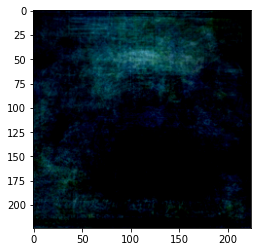

In [19]:

out_img=torch.movedim(mean_images[0],0,2)
plt.imshow(out_img.cpu().numpy())

In [20]:
stack = torch.stack(mean_images)

In [21]:
stack.size()

torch.Size([313, 3, 224, 224])

In [24]:
test_mean = torch.mean(stack,dim=0)

In [25]:
test_mean.size()

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


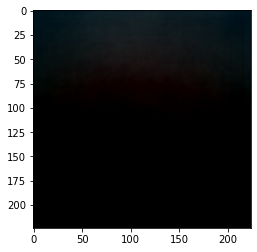

In [26]:
out_img=torch.movedim(test_mean,0,2)
plt.imshow(out_img.cpu().numpy())

In [29]:
out_img.size()

torch.Size([224, 224, 3])

In [30]:
encoded_mean_image = model.encode_image(test_mean.unsqueeze(0))

In [39]:
torch.save(encoded_mean_image,'vit_encoded_meanimage.pt')

In [199]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df['target_cat'].values, df['pred_1'].values, labels=imagenet_classes )

/home/dlesser/anaconda3/envs/CLIP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:309: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif np.all([l not in y_true for l in labels]):


ValueError: At least one label specified must be in y_true

In [197]:
df['pred_1'].values

array([ 81,  81, 150, ..., 531, 990, 946])

In [200]:
df['target_cat'].values

array([ 81,  81,  81, ..., 946, 946, 946])

In [202]:
imagenet_classes

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead shark',
 'electric ray',
 'stingray',
 'rooster',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'American robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'American dipper',
 'kite (bird of prey)',
 'bald eagle',
 'vulture',
 'great grey owl',
 'fire salamander',
 'smooth newt',
 'newt',
 'spotted salamander',
 'axolotl',
 'American bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead sea turtle',
 'leatherback sea turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'green iguana',
 'Carolina anole',
 'desert grassland whiptail lizard',
 'agama',
 'frilled-necked lizard',
 'alligator lizard',
 'Gila monster',
 'European green lizard',
 'chameleon',
 'Komodo dragon',
 'Nile crocodile',
 'American alligator',
 'triceratops',
 'worm snake',
 'ring-necked snake',
 'eastern hog-nosed snake',
 'smooth green snake',
 'kingsnake',
 'garter snake',
 'w

In [218]:
imagenet_classes[83]

'prairie grouse'

In [219]:
imagenet_classes[81]

'ptarmigan'